In [1]:
# Modules I'll need
import pandas as pd
import numpy as np
from warnings import filterwarnings
from matplotlib import pyplot as plt

In [2]:
filterwarnings('ignore')

In [3]:
# Parameters for the ibnr model
val_year = '2023-2024'
disc_rate = 0.04

In [4]:
# Import the raw data
raw_data = pd.read_excel('Raw Data.xlsx')
raw_data.head()

,Cust_No,Incurred_Date,Paid_Date,Industry_Code,Amount_$
0,714204,2017-11-13,2020-01-20,154,6794.57
1,194876,2019-09-18,2022-07-25,599,8503.89
2,669125,2015-11-29,2023-03-10,952,6348.72
3,652323,2016-09-27,2020-05-30,952,9531.88
4,698983,2017-07-21,2017-11-16,184,3242.67


### FUNCTIONS I'LL USE

In [5]:
# A FUNCTION FO CONVERTING DATES TO FISCAL YEARS
def date_to_fy_year(date_):
    if date_.month <= 6:
        return f'{date_.year-1}-{date_.year}'
    elif date_.month > 6:
        return f'{date_.year}-{date_.year+1}'

In [6]:
# To help reverse dfs
def reverse_list(input:list):
    output = []
    n = len(input)
    for i in range(n):
        output.append(input[n-i-1])
    return output

In [7]:
# to return the minor diagonal of a table
def minor_diag(df:pd.DataFrame, offset:int=0):
    output = []
    if ult_incr_tri.shape[0] != ult_incr_tri.shape[1]:
        raise Exception('Dataframe must be symmetric')
    else:
        n = ult_incr_tri.shape[0]
        if abs(offset) > n:
            raise KeyError('Offset cannot be greater than frame dimentions')
        else:
            for i,j in zip(range(offset, n), reverse_list(range(offset, n))):
                output.append(df.iloc[i,j])
    return output

In [8]:
# COPY THE DATASET AND START THE ANALYSIS:
ibnr_data = raw_data.copy()
ibnr_data.shape

(1342, 5)

In [9]:
# 1. PERFORM THE DATE CHECK - PAID DATE SHOULD BE GREATER THAN INCURRED DATE
assert(sum(ibnr_data['Incurred_Date'] <= ibnr_data['Paid_Date']) == ibnr_data.shape[0])

In [10]:
# 2. INSERT THE FISCAL YEAR COLUMNS AND LAG COLUMN
ibnr_data['Incurred_Year'] = ibnr_data['Incurred_Date'].apply(lambda x:date_to_fy_year(x))
ibnr_data['Paid_Year'] = ibnr_data['Paid_Date'].apply(lambda x:date_to_fy_year(x))
ibnr_data.head()

,Cust_No,Incurred_Date,Paid_Date,Industry_Code,Amount_$,Incurred_Year,Paid_Year
0,714204,2017-11-13,2020-01-20,154,6794.57,2017-2018,2019-2020
1,194876,2019-09-18,2022-07-25,599,8503.89,2019-2020,2022-2023
2,669125,2015-11-29,2023-03-10,952,6348.72,2015-2016,2022-2023
3,652323,2016-09-27,2020-05-30,952,9531.88,2016-2017,2019-2020
4,698983,2017-07-21,2017-11-16,184,3242.67,2017-2018,2017-2018


In [11]:
# LIST YOUR FYs AND LAGS FOR LATER USE WHEN DOING CALCULATIONS IN THE MATRIX
fys = sorted(ibnr_data['Paid_Year'].unique())
n = len(fys)
lags = list(range(n))

In [12]:
# INSERT THE LAG COLUMN
ibnr_data['Lag'] = np.subtract([int(i[:4]) for i in ibnr_data['Paid_Year']], [int(i[:4]) for i in ibnr_data['Incurred_Year']])

In [13]:
# CREATE A MATRIX FOR USE AS YOUR 'TRIANGLE'
# FIRST CREATE AN EMPTY INCREMENTAL TRIANLGE THEN FILL IT IN WITH ACTUAL AMOUNTS
incr_tri = pd.DataFrame(index=fys, columns=lags)
for i in incr_tri.index:
    for j in incr_tri.columns:
        if int(i[:4])+j > int(val_year[:4]):
            pass
        else:
            incr_tri.loc[i, j] = ibnr_data[ibnr_data['Incurred_Year']==i][ibnr_data['Lag']==j]['Amount_$'].sum()
incr_tri

,0,1,2,3,4,5,6,7,8,9
2014-2015,8744.2,13820.48,6827.12,6010.42,17103.06,18353.61,53838.37,80081.42,88970.13,110393.21
2015-2016,12650.1,45835.44,35642.24,69533.19,95600.13,118541.18,134323.02,136113.15,122770.31,NaN
2016-2017,47477.57,100430.56,137829.82,110801.62,74551.8,110023.33,170243.63,22644.6,NaN,NaN
2017-2018,42739.8,80898.01,124914.21,97953.51,127404.92,91315.71,32953.61,NaN,NaN,NaN
2018-2019,102987.72,120908.07,125585.61,103002.23,138546.41,65062.68,NaN,NaN,NaN,NaN
2019-2020,137095.99,212206.58,206240.54,205004.93,94388.39,NaN,NaN,NaN,NaN,NaN
2020-2021,110830.19,252858.84,294909.35,114556.98,NaN,NaN,NaN,NaN,NaN,NaN
2021-2022,126212.04,367208.97,183824.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-2023,373267.68,439332.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-2024,236686.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# A check to confirm the triangle numbers match the original data set
assert(np.sum(incr_tri).sum() == ibnr_data['Amount_$'].sum())
np.sum(incr_tri, axis=1) - ibnr_data.groupby('Incurred_Year')['Amount_$'].sum()

2014-2015    0.0
2015-2016    0.0
2016-2017   -0.0
2017-2018    0.0
2018-2019    0.0
2019-2020    0.0
2020-2021   -0.0
2021-2022    0.0
2022-2023   -0.0
2023-2024    0.0
dtype: object

In [15]:
# All Good

In [16]:
ptd = np.sum(incr_tri, axis=1) # paid-to-date amounts by FY

In [17]:
# CREATE THE CUMULATIVE TRIANGLE
cum_tri = np.cumsum(incr_tri, axis=1)

In [18]:
# CALCULATE DEVELOPMENT FACTORS USING THE CUMULATED TRIANGLE
dfs = []
for i in lags[-(n-1):]:
    df = cum_tri[i][:(n-i)].sum() / cum_tri[i-1][:(n-i)].sum()
    dfs.append(df)
dfs

[2.6980152468808147,
 1.6258179686297958,
 1.318201385408777,
 1.2540877716359544,
 1.2182578710541472,
 1.2453655999422146,
 1.1720519074426965,
 1.248225308206882,
 1.3758081947634104]

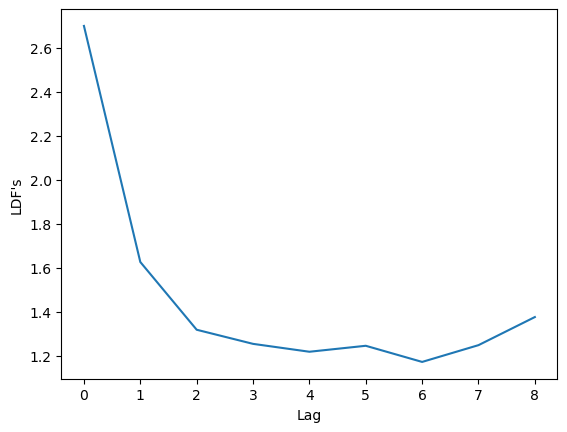

In [19]:
# plot dfs to check the pattern
plt.plot(dfs)
plt.xlabel('Lag')
plt.ylabel('LDF\'s')
plt.show()

In [20]:
# calculate the cumulative development factors
cum_dfs = dfs + [1]
cum_dfs.reverse()
cum_dfs = np.cumprod(cum_dfs).tolist()
cum_dfs.reverse()
cum_dfs

[22.144191503367615,
 8.207585753627077,
 5.048280872762314,
 3.8296734691997245,
 3.0537523415956165,
 2.506655129552525,
 2.0127865501253885,
 1.7173186079421119,
 1.3758081947634104,
 1.0]

In [21]:
# calculate ultimate amounts by FY from paid to date and cumulative dfs.
ult = ptd*reverse_list(cum_dfs)

In [22]:
# reserve by FY
forecast_payments = ult - ptd
forecast_payments

2014-2015               0.0
2015-2016     289751.410242
2016-2017     555206.704291
2017-2018     605828.425613
2018-2019      988505.46205
2019-2020    1755827.695028
2020-2021    2187777.209762
2021-2022    2741681.339747
2022-2023     5856886.92228
2023-2024     5004543.41361
dtype: object

In [23]:
f'Reserve ={round(forecast_payments.sum()) : ,}'

'Reserve = 19,986,009'

## END OF PART I

## PART II - BREAKING DOWN THE FORECAST PAYMENTS BY THE YEAR WHEN THEY ARE DUE

In [24]:
# FILL IN THE RIGHT-HAND SIDE OF THE CUMULATIVE TRIANGLE BY APPLYING DFs TO EACH ELEMENT OF THE TRIANGLE
ult_cum_tri = cum_tri.copy()
for i in fys:
    for j in lags:
        if np.isnan(ult_cum_tri.loc[i,j]):
            ult_cum_tri.loc[i,j] = ult_cum_tri.loc[i,j-1] * dfs[j-1]
ult_cum_tri

,0,1,2,3,4,5,6,7,8,9
2014-2015,8744.2,22564.68,29391.8,35402.22,52505.28,70858.89,124697.26,204778.68,293748.81,404142.02
2015-2016,12650.1,58485.54,94127.78,163660.97,259261.1,377802.28,512125.3,648238.45,771008.76,1060760.170242
2016-2017,47477.57,147908.13,285737.95,396539.57,471091.37,581114.7,751358.33,774002.93,966130.045852,1329209.634291
2017-2018,42739.8,123637.81,248552.02,346505.53,473910.45,565226.16,598179.77,701097.740422,875127.943122,1204008.195613
2018-2019,102987.72,223895.79,349481.4,452483.63,591030.04,656092.72,817075.303861,957654.668414,1195368.793637,1644598.18205
2019-2020,137095.99,349302.57,555543.11,760548.04,854936.43,1041533.035098,1297089.413115,1520256.120765,1897622.164895,2610764.125028
2020-2021,110830.19,363689.03,658598.38,773155.36,969604.682551,1181228.536328,1471061.384814,1724160.302036,2152140.524407,2960932.569762
2021-2022,126212.04,493421.01,677245.83,892746.391368,1119582.332587,1363939.988967,1698603.942646,1990851.990967,2485031.84002,3418927.169747
2022-2023,373267.68,812600.38,1321140.299119,1741528.972619,2184030.188511,2660711.967773,3313559.156019,3883663.329236,4847686.856108,6669487.30228
2023-2024,236686.44,638583.62385,1038220.730128,1368584.004815,1716324.464895,2090925.788641,2603967.049205,3051984.546939,3809564.351746,5241229.85361


In [25]:
# DIFFERENCE THE ULTIMATE CUMULATIVE TRIANGLE TO CREATE AN ULTIMATE INCREMENTAL TRIANGLE
ult_incr_tri = ult_cum_tri.copy()
for i in lags[1:]:
    ult_incr_tri[i] = ult_cum_tri[i] - ult_cum_tri[i-1]
ult_incr_tri    

,0,1,2,3,4,5,6,7,8,9
2014-2015,8744.2,13820.48,6827.12,6010.42,17103.06,18353.61,53838.37,80081.42,88970.13,110393.21
2015-2016,12650.1,45835.44,35642.24,69533.19,95600.13,118541.18,134323.02,136113.15,122770.31,289751.410242
2016-2017,47477.57,100430.56,137829.82,110801.62,74551.8,110023.33,170243.63,22644.6,192127.115852,363079.588438
2017-2018,42739.8,80898.01,124914.21,97953.51,127404.92,91315.71,32953.61,102917.970422,174030.202699,328880.252492
2018-2019,102987.72,120908.07,125585.61,103002.23,138546.41,65062.68,160982.583861,140579.364554,237714.125223,449229.388413
2019-2020,137095.99,212206.58,206240.54,205004.93,94388.39,186596.605098,255556.378017,223166.70765,377366.04413,713141.960132
2020-2021,110830.19,252858.84,294909.35,114556.98,196449.322551,211623.853778,289832.848485,253098.917222,427980.222371,808792.045355
2021-2022,126212.04,367208.97,183824.82,215500.561368,226835.941219,244357.65638,334663.953678,292248.048322,494179.849052,933895.329727
2022-2023,373267.68,439332.7,508539.919119,420388.673499,442501.215892,476681.779262,652847.188246,570104.173217,964023.526871,1821800.446172
2023-2024,236686.44,401897.18385,399637.106278,330363.274687,347740.46008,374601.323746,513041.260565,448017.497734,757579.804807,1431665.501865


In [26]:
# NOW ASSIGN THE AMOUNT DUE AT EACH FUTURE FY, START BY LISTING DOWN FUTURE FYs
future_fys = []
for i in lags[1:]:
    future_fys.append(f'{int(val_year[:4])+i}-{int(val_year[:4])+i+1}')
future_fys

['2024-2025',
 '2025-2026',
 '2026-2027',
 '2027-2028',
 '2028-2029',
 '2029-2030',
 '2030-2031',
 '2031-2032',
 '2032-2033']

In [27]:
# NOW GET THE NOMINAL CASHFLOWS BY FYs
future_payments = []
for i in lags[1:]:
    amount = sum(minor_diag(ult_incr_tri, i))
    future_payments.append([round(amount,3), round(amount/(1+disc_rate)**i,3)])
future_payments

[[2254762.672, 2168041.031],
 [2191731.108, 2026378.614],
 [2096816.081, 1864061.861],
 [2238780.543, 1913718.991],
 [2460818.743, 2022613.63],
 [2386117.328, 1885783.185],
 [2345936.354, 1782718.824],
 [2579380.251, 1884727.884],
 [1431665.502, 1005869.191]]

In [28]:
# ET VOILA!
cashflows = pd.DataFrame(future_payments, columns=['Nominal', 'Discounted'], index=future_fys)
cashflows

,Nominal,Discounted
2024-2025,2254762.672,2168041.031
2025-2026,2191731.108,2026378.614
2026-2027,2096816.081,1864061.861
2027-2028,2238780.543,1913718.991
2028-2029,2460818.743,2022613.630
2029-2030,2386117.328,1885783.185
2030-2031,2345936.354,1782718.824
2031-2032,2579380.251,1884727.884
2032-2033,1431665.502,1005869.191
